# DLL Final Project - Knowledge Distillation and Student Teacher Models
$\textit{Author: Onno Niemann}$

##Table of Contents
1. Load MNIST Data
2. Define LeNet-5 Model Architecture
3. Teacher Training
4. Knowledge Distillation - Loss Function and Detailed Background
5. Knowledge Distillation (Student Training)
6. Experiments
7. Conclusions and Future Research



This notebook provides an introduction to the topic of knowledge distillation by re-producing parts of the results of the paper $\textit{Does Knowledge Distillation Really Work?}$ from 2021 by Stanton et al. [3].
- Problem knowledge distillation aims to solve: Complex models are slow at inference and require large memory -> especially problematic when deployed to small devices
- Idea: Distill knowledge of complex model (teacher) into simpler model (student) to save memory and enable fast inference

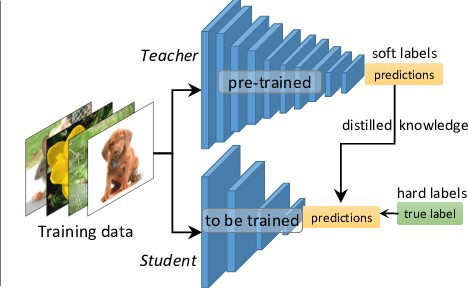 

Image from [4]

In general knowledge distillation is a 2-stage process:

1. Define and train teacher model
2. Define student model and train it using the teacher to generate soft labels


The goal of Stanton et al. [3] is a more thorough understanding of knowledge distillation. The main experiments conducted in the paper investigate self-distillation, meaning student and teacher model have the same model architecture. Self-distillation is interesting, because in principle the student model has the capacity to perfectly imitate the teacher. In the following I will reproduce the first experiment, self-distillation of a Convolutional Neural Network (LeNet-5) trained on MNIST handwritten digits.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AvgPool2D
from tensorflow.keras.activations import softmax
from tensorflow.keras import Sequential
from tensorflow.keras import Model as Model_

## Load MNIST Data

In [2]:
#Helper function to show loaded images
def show_tensor_images(image_tensor, num_images=16, size=[28, 28,1]):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    imgs = image_tensor[:num_images]
    image_unflat = tf.reshape(imgs,[num_images, *size])
    fig = plt.figure(figsize=(4,4))
    for i in range(image_unflat.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(image_unflat[i, :, :, 0], cmap='gray')
        plt.axis('off')

11501568/11490434 [==============================] - 0s 0us/step
Shape of train set:  (60000, 28, 28)
Shape of test set:  (10000, 28, 28)
Example Images


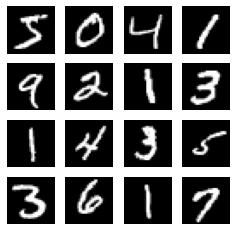

In [3]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
print("Shape of train set: ", x_train.shape)
print("Shape of test set: ", x_test.shape)
print("Example Images")
show_tensor_images(x_train)

## Define LeNet-5 Model Architecture

Architecture as defined in original paper from 1998 [2]:

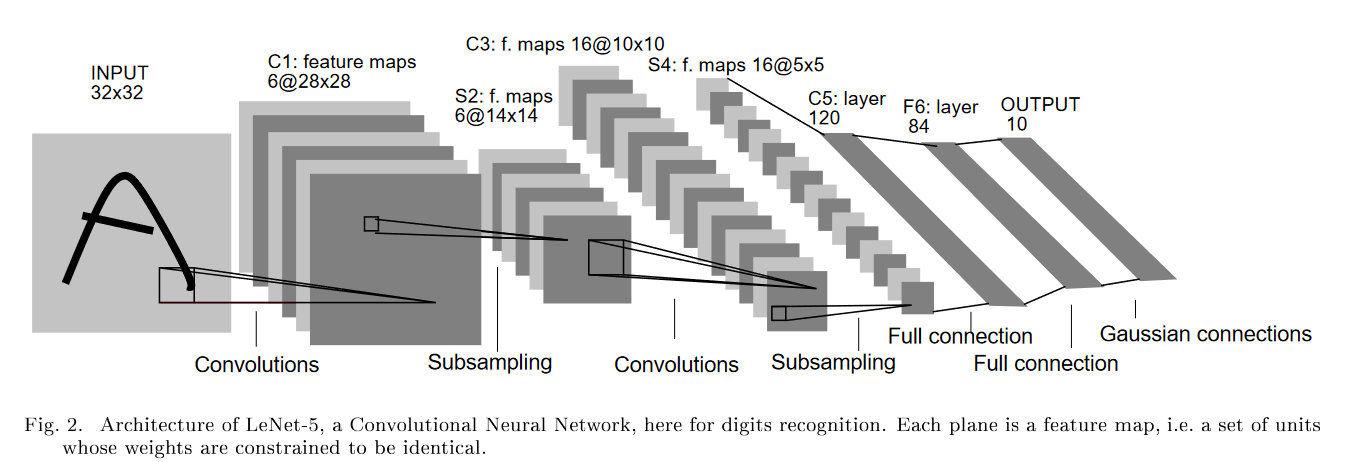

In [4]:
class ConvolutionBlock(Model_):
  def __init__(self, num_ch, inp_shape, pad='same'):
    super(ConvolutionBlock, self).__init__()
    self.conv_layer = Conv2D(num_ch, 5, padding=pad, activation='relu', \
                             input_shape=inp_shape)
    self.pool_layer = AvgPool2D(pool_size=(2, 2), padding='valid')
    self.block = Sequential([self.conv_layer, self.pool_layer]) 

  def call(self, input_x):
    return self.block(input_x)

In [5]:
class LeNet(Model_):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv_block_1 = ConvolutionBlock(6, inp_shape=(28,28,1))
    self.conv_block_2 = ConvolutionBlock(16, pad='valid', inp_shape=(14,14,6))
    self.flat = Flatten()
    self.dense_1 = Dense(120, activation='ReLU')
    self.dense_2 = Dense(84, activation='ReLU')
    self.out = Dense(10, activation=None)
    self.model = Sequential([self.conv_block_1, self.conv_block_2, self.flat, \
                             self.dense_1, self.dense_2, self.out])
  
  def call(self, input_x, probs=True):
    if probs:
      result = softmax(self.model(input_x))
    else:
      result = self.model(input_x)
    return result

## Teacher Optimizer
The first optimizer is used to pre-train the teacher model on the task of image classification. L2 regularization is added to avoid over-fitting on the training data, adding the term $\lambda\sum_{j=1}^p\beta_j^2$ to the negative-log-likelihood objective function. L2 regularization makes smaller parameter values favorable. 

In [6]:
class Teacher_Optimizer: 
  def __init__(self, model, mb, lr, reg):
    self.model = model
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy()
    self.optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    self.mb = mb
    self.regularizer = tf.keras.regularizers.l2(reg)
    
    self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    self.test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

  @tf.function
  def train_step(self, x , y):
    with tf.GradientTape() as tape:
      predictions = self.model(x)
      loss = self.loss(y, predictions)
      loss_reg = loss + tf.math.add_n([self.regularizer(v) \
                            for v in self.model.trainable_variables if 'bias' not in v.name])
    gradients = tape.gradient(loss_reg, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
    self.train_accuracy(y, predictions)
    return loss

  @tf.function
  def test_step(self, x , y):
    predictions = self.model(x)
    loss = self.loss(y, predictions)
    self.test_accuracy(y, predictions)

  def train(self):
    for mbX, mbY in self.train_ds:
      self.train_step(mbX, mbY)
  
  def test(self):
    for mbX, mbY in self.test_ds:
      self.test_step(mbX, mbY)    
  
  def run(self, dataX, dataY, testX, testY, epochs, verbose=2):
    historyTR = []
    historyTS = []
    template = '{} {}, {}: {}, {}: {}'
    old_accuracy = 0
    self.train_ds = tf.data.Dataset.from_tensor_slices((dataX, dataY)).shuffle(16000).batch(self.mb)
    self.test_ds = tf.data.Dataset.from_tensor_slices((testX,testY)).batch(self.mb)
    for i in range(epochs):
      self.train()
      self.test()
      #check whether test accuracy has improved, if so save weights
      if self.test_accuracy.result() > old_accuracy:
        self.model.save_weights("best_teacher")
      if verbose > 0:
        print(template.format("epoch: ", i+1,
                      " TRAIN ACC: " , self.train_accuracy.result()*100,
                      " TEST ACC: "  , self.test_accuracy.result()*100))
      temp = '{}'
      historyTR.append(float(temp.format(self.train_accuracy.result())))
      historyTS.append(float(temp.format(self.test_accuracy.result())))
      old_accuracy = self.test_accuracy.result() #to check in the next iteration
      self.train_accuracy.reset_states()
      self.test_accuracy.reset_states()
    return historyTR, historyTS

## Helper Function for Plotting

In [7]:
def plotting_function(title, tr, ts, teacher_perf=None, ts_a=None, agr=False):
  fig, ax = plt.subplots(figsize=(12,5)) 
  ax.set_title(title, fontsize=16)
  ax.plot(np.array(ts)*100, label='TEST ACC')
  ax.plot(np.array(tr)*100, label='TRAIN ACC')
  if agr: #also plot student teacher agreement and teacher performance
    ax.plot(np.array(ts_a)*100, label='TEST AGREEMENT')  
    ax.plot([teacher_perf*100 for i in range(len(ts_a))], '--', label='TEACHER ACC')
  ax.set_xlabel('Iteration')
  ax.legend()
  plt.show()

## Teacher Training
The task of MNIST image classification is too simple when training on the whole train set. For this reason Stanton et al. [3] train the teacher model on a randomly selected subset of 200 images. 

Hyperparameters:

batch size = 100 (2 batches)

$\mu = 0.001$ (learning rate)

$\lambda=0.5$ (regularization strength)


In [8]:
def train_teacher(model, mb, lr, reg, verbose=2):
  opt = Teacher_Optimizer(model, mb, lr=lr, reg=reg)
  random_indices = np.random.choice(x_train.shape[0], size=200, replace=False)
  rand_x_train = x_train[random_indices]
  rand_y_train = y_train[random_indices]
  tr, ts = opt.run(rand_x_train, rand_y_train, x_test, y_test, epochs=100, verbose=verbose)
  return tr, ts

In [9]:
teacher = LeNet()
tr, ts = train_teacher(teacher, 100, 0.001, reg=0.5)
teacher_performance = np.max(ts) #save this for use in distillation plot

epoch:  1,  TRAIN ACC: : 8.0,  TEST ACC: : 14.210000991821289
epoch:  2,  TRAIN ACC: : 18.0,  TEST ACC: : 21.690000534057617
epoch:  3,  TRAIN ACC: : 23.0,  TEST ACC: : 27.689998626708984
epoch:  4,  TRAIN ACC: : 32.5,  TEST ACC: : 30.75
epoch:  5,  TRAIN ACC: : 36.0,  TEST ACC: : 37.85000228881836
epoch:  6,  TRAIN ACC: : 48.0,  TEST ACC: : 46.22999954223633
epoch:  7,  TRAIN ACC: : 52.0,  TEST ACC: : 53.96000289916992
epoch:  8,  TRAIN ACC: : 59.500003814697266,  TEST ACC: : 60.439998626708984
epoch:  9,  TRAIN ACC: : 65.5,  TEST ACC: : 62.94999694824219
epoch:  10,  TRAIN ACC: : 71.0,  TEST ACC: : 64.44000244140625
epoch:  11,  TRAIN ACC: : 75.0,  TEST ACC: : 65.81999969482422
epoch:  12,  TRAIN ACC: : 78.0,  TEST ACC: : 67.66999816894531
epoch:  13,  TRAIN ACC: : 83.5,  TEST ACC: : 69.76000213623047
epoch:  14,  TRAIN ACC: : 86.5,  TEST ACC: : 71.63999938964844
epoch:  15,  TRAIN ACC: : 87.5,  TEST ACC: : 72.45999908447266
epoch:  16,  TRAIN ACC: : 90.5,  TEST ACC: : 73.01999664306

The teacher model achieves a test accuracy of above 86%. The authors report an accuracy between 84% and 86% in their training.

I found adding regularization to improve performance.

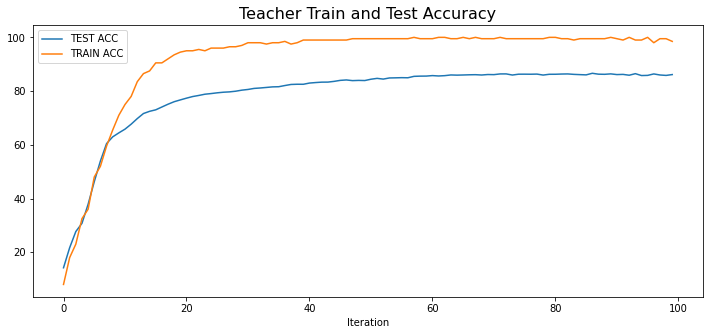

In [10]:
plotting_function('Teacher Train and Test Accuracy', tr, ts)

## Knowledge Distillation - Loss Function and Theoretical Background
Before defining the second optimizer for student training, some concepts of knowledge distillation need to be clear. The first important one is the student objective function. A standard negative-log-likelihood classification loss $L_{NLL}$ and a distillation loss $L_{KD}$ are combined in a weighted way. The distillation loss is lower the more similar the output of student and teacher models are.  

Full Objective Function of Student Training [3]: 

$$\begin{equation}L_S=\alpha L_{NLL}(z_S,y)+(1-\alpha)L_{KD}(z_S, z_T)\end{equation}$$

Negative Log Likelihood Loss:

$$L_{NLL}(z_S,y)=-\sum_{j=1}^cy_j\log\sigma_j(z_S) $$

Knowledge Distillation Loss:

$$L_{KD}(z_S, z_T)=-\tau^2\sum_{j=1}^c\sigma_j(\frac{z_T}{\tau})\log\sigma_j(\frac{z_T}{\tau})$$

$\alpha$ - trade-off parameter between learning teacher logits and direct classification

$\sigma_j(.)$ - softmax over vector j

$y$ - true labels

$z_S$ - student logits

$z_T$ - teacher logits

$\tau$ - logit scaling factor called temperature

### Illustration of the temperature parameter $\tau$

In $\textit{Distilling the Knowledge in a Neural Network}$ Hinton et al. argue that neural networks generally use a softmax function to convert the output logits $z_i$ into class probabilities $q_i$ where normally a temperature of 1 is chosen: 

$q_i=\frac{e^{\frac{z_i}{\tau}}}{\sum_je^{\frac{z_j}{\tau}}}$

Choosing $\tau>1$ produces a softer class probability distribution [1]. The idea is that the student model does not only learn the class with highest assigned probability, but can benefit also from the teacher probability distribution over the less likely classes. 

In the following I will demonstrate the effect of the parameter $\tau$ by showing its effect on the class probability distribution calculated from a randomly chosen set of logits [6, 3, -1, 0.5, 1.3, 0.1, -5, 2.1, 0.9, 0.2] 

(1, 10)


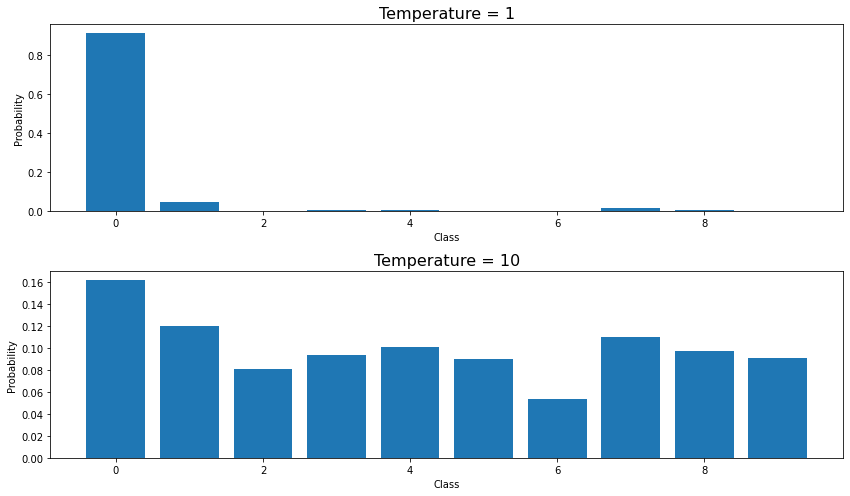

In [39]:
#@title Comparing two temperature values
arbitrary_logits = tf.convert_to_tensor(np.array([[6, 3, -1, 0.5, 1.3, 0.1, -5, 2.1, 0.9, 0.2]]))

standard_probs = softmax(arbitrary_logits).numpy() #standard softmax of logits
scaled_probs = softmax(arbitrary_logits/10).numpy() #softmax of rescaled logits

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,7)) 
x = range(10)
ax[0].set_title("Temperature = 1", fontsize=16)
ax[0].bar(x, standard_probs[0])
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Probability')
ax[1].set_title("Temperature = 10", fontsize=16)
ax[1].bar(x, scaled_probs[0])
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Probability')
plt.tight_layout()

It is clear that a higher temparature softens the distribution of class probabilities and might therefore help student traing by extracting more information from the teacher logits.

### Student-Teacher-Agreement

Another point needed before the definition of the student optimizer is a metric for the student-teacher-agreement. This metric is helpful for understanding the process of knowledge distillation.

The degree of agreement is evaluated by the Average-Top-1-Agreement defined as follows [3]:
$$\frac{1}{n}\sum_{i=1}^nI\{argmax_j \sigma_j(z_{t,i})=argmax_j \sigma_j(z_{s,i})\}$$

Intuitively, this metric describes how often the student and teacher predict the same class. 

In code with examples it looks as follows:

In [11]:
m = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
states_1 = [[[0.1, 0.9, 0.6], [0.2, 0.5, 0.3]], [[0.1, 0.6, 0], [0.05, 0.95, 0]]]
m.update_state(*states_1)
print('Top one agreement of {} and {}: \n{}'.format(*states_1, m.result().numpy()))
m.reset_state()
states_2 = [[[0.1, 0.4, 0.6], [0.2, 0.5, 0.3]], [[0.1, 0.6, 0], [0.05, 0.95, 0]]]
m.update_state(*states_2)
print('Top one agreement of {} and {}: \n{}'.format(*states_2, m.result().numpy()))

Top one agreement of [[0.1, 0.9, 0.6], [0.2, 0.5, 0.3]] and [[0.1, 0.6, 0], [0.05, 0.95, 0]]: 
1.0
Top one agreement of [[0.1, 0.4, 0.6], [0.2, 0.5, 0.3]] and [[0.1, 0.6, 0], [0.05, 0.95, 0]]: 
0.5


In the first row both instances in both test cases assign highest value to index 1 resulting in a top-1-agreement of 100%. In the second row, the first instance ([0.1, 0.4, 0.6]) has its maximum at index 2, while [0.1, 0.6, 0] is highest at index 1. Since the other test case has the highest value at index 1 in both instances, the top-1-agreement is 0.5.

## Student Optimizer

In [12]:
class Student_Optimizer: 
  def __init__(self, teacher_model, student_model, alpha, tau, mb, lr):
    self.teacher = teacher_model
    self.student = student_model
    self.alpha = alpha #weighting of different losses  
    self.tau = tau #temperature for softening class probabilities
    self.ce_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    #We need anpother cross entropy loss to compare logits, because logits are not sparse
    self.kd_loss = tf.keras.losses.CategoricalCrossentropy() 
    self.optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    self.mb = mb
    
    self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    self.test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
    self.train_agreement = tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='train_agreement')
    self.test_agreement = tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='test_agreement')
    
  @tf.function
  def train_step(self, x , y):
    z_t = self.teacher(x, probs=False)/self.tau#re-scaled teacher logits
    with tf.GradientTape() as tape:
      z_s = self.student(x, probs=False)/self.tau#re-scaled student logits
      kd_loss = self.tau**2*self.kd_loss(softmax(z_t), softmax(z_s))
      stud_predictions = self.student(x)
      ce_loss = self.ce_loss(y, stud_predictions)
      total_loss = self.alpha*ce_loss+(1-self.alpha)*kd_loss
    gradients = tape.gradient(total_loss, self.student.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))
    self.train_accuracy(y, stud_predictions)
    self.train_agreement(z_t, stud_predictions)
    return total_loss

  @tf.function
  def test_step(self, x , y):
    teach_predictions = self.teacher(x)
    stud_predictions = self.student(x)
    loss = self.ce_loss(y, stud_predictions)
    self.test_accuracy(y, stud_predictions)
    self.test_agreement(teach_predictions, stud_predictions)

  def train(self):
    for mbX, mbY in self.train_ds:
      self.train_step(mbX, mbY)
  
  def test(self):
    for mbX, mbY in self.test_ds:
      self.test_step(mbX, mbY)    
  
  def run(self, dataX, dataY, testX, testY, epochs, verbose=2):
    historyTR = []
    historyTS = []
    historyTR_A = [] #train agreement
    historyTS_A = []
    template = '{} {}, {}: {}, {}: {}, {}: {}, {}: {}'
    self.train_ds = tf.data.Dataset.from_tensor_slices((dataX, dataY)).shuffle(16000).batch(self.mb)
    self.test_ds = tf.data.Dataset.from_tensor_slices((testX,testY)).batch(self.mb)
    for i in range(epochs):
      self.train()
      self.test()
      if verbose > 0:
        print(template.format("epoch: ", i+1,
                      " TRAIN ACC: " , self.train_accuracy.result()*100,
                      " TEST ACC: "  , self.test_accuracy.result()*100,
                      " TRAIN AGR: "  , self.train_agreement.result()*100,
                      " TEST AGR: "  , self.test_agreement.result()*100))
      temp = '{}'
      historyTR.append(float(temp.format(self.train_accuracy.result())))
      historyTS.append(float(temp.format(self.test_accuracy.result())))
      historyTR_A.append(float(temp.format(self.train_agreement.result())))
      historyTS_A.append(float(temp.format(self.test_agreement.result())))
      
      self.train_accuracy.reset_states()
      self.test_accuracy.reset_states()
      self.train_agreement.reset_states()
      self.test_agreement.reset_states()
    return historyTR, historyTS, historyTR_A, historyTS_A

## Knowledge Distillation (Student Training)
The parameter $\alpha$ is set to zero to ensure the student's goal is imitation of the teacher rather than a high prediction accuracy. 

Hyperparameters:

batch size = 100

$\mu=1e-4$

$\alpha=0$ (student has no information on true labels)

$\tau=20$ (temperature - logit scaling factor)

In [13]:
def run_distillation(teacher, student, alpha, tau, mb, lr, epochs, verbose=2):
  opt = Student_Optimizer(teacher, student, alpha, tau, mb, lr)
  tr, ts, tr_a, ts_a = opt.run(x_train, y_train, x_test, y_test, epochs, verbose=verbose)
  return tr, ts, tr_a, ts_a

In [14]:
teacher.load_weights("best_teacher")
student = LeNet()
tr, ts, tr_a, ts_a = run_distillation(teacher, student, alpha=0, tau=20, mb=100, lr=1e-4, epochs=30)

epoch:  1,  TRAIN ACC: : 44.40500259399414,  TEST ACC: : 65.94000244140625,  TRAIN AGR: : 46.345001220703125,  TEST AGR: : 68.7699966430664
epoch:  2,  TRAIN ACC: : 71.9866714477539,  TEST ACC: : 76.33000183105469,  TRAIN AGR: : 75.9566650390625,  TEST AGR: : 80.51000213623047
epoch:  3,  TRAIN ACC: : 78.06166076660156,  TEST ACC: : 80.19999694824219,  TRAIN AGR: : 82.99833679199219,  TEST AGR: : 85.45999908447266
epoch:  4,  TRAIN ACC: : 80.76499938964844,  TEST ACC: : 82.13999938964844,  TRAIN AGR: : 86.71833038330078,  TEST AGR: : 88.30999755859375
epoch:  5,  TRAIN ACC: : 82.29167175292969,  TEST ACC: : 83.20999908447266,  TRAIN AGR: : 89.25167083740234,  TEST AGR: : 90.41000366210938
epoch:  6,  TRAIN ACC: : 83.30833435058594,  TEST ACC: : 84.1300048828125,  TRAIN AGR: : 91.01499938964844,  TEST AGR: : 91.5999984741211
epoch:  7,  TRAIN ACC: : 83.95500183105469,  TEST ACC: : 84.44999694824219,  TRAIN AGR: : 92.20832824707031,  TEST AGR: : 92.68000030517578
epoch:  8,  TRAIN ACC: :

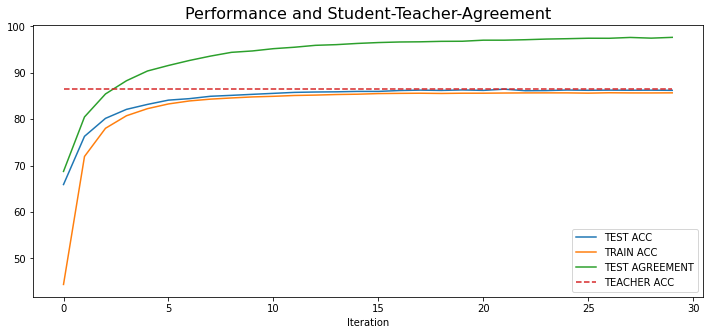

In [40]:
plotting_function('Performance and Student-Teacher-Agreement', tr, ts, teacher_performance, ts_a, agr=True)

The student reaches the performance level of the teacher. 

## Experiments
In the following I show that the implemented knowledge distillation process yields roughly the same results as provided by Stanton et al. [3]. 

The paper presents the following results on MNIST [3]. In addition to the distillation on MNIST they use EMNIST data. This notebook will only use MNIST data, since that appears to be sufficient for the student to learn. For this reason, only the left-most entry (MNIST 60k) is relevant to the experiments below. 

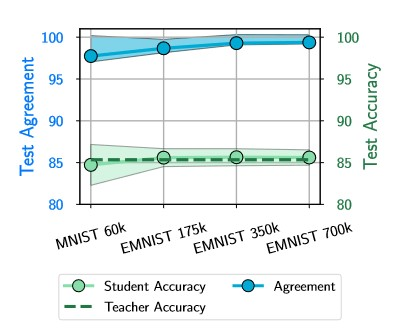

Hyperparameters:

Number of teacher models trained = 3

Number of student models trained per teacher = 3

Hyperparameters for student and teacher training are the same as in the respective section above.

Teacher Model 1 Test Accuracy: 0.8588
Student Model 1 Test Accuracy final/maximal:0.8479/0.8501 Agreement final/maximal:0.9811/0.9822


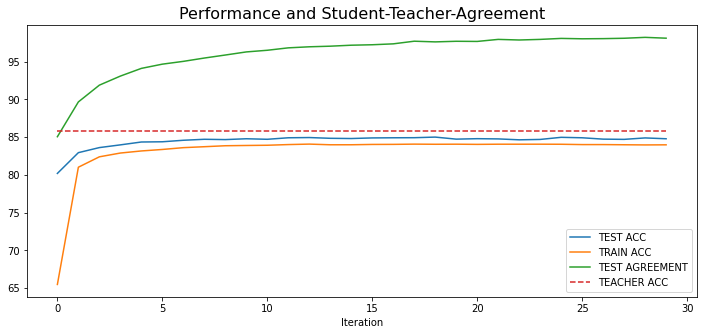

Student Model 2 Test Accuracy final/maximal:0.8493/0.8514 Agreement final/maximal:0.9825/0.9825


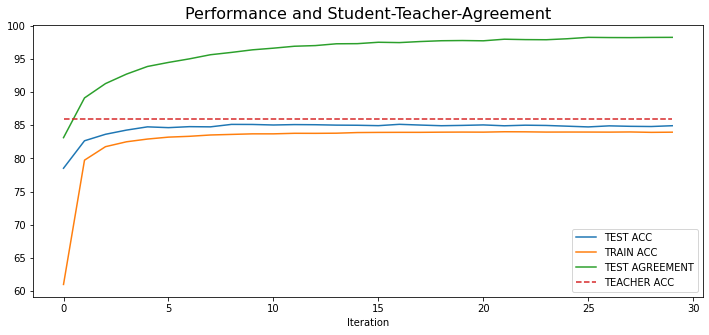

Student Model 3 Test Accuracy final/maximal:0.8498/0.8498 Agreement final/maximal:0.9788/0.9788


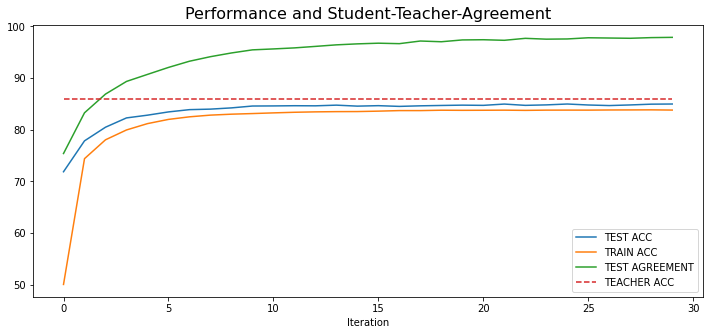

Teacher Model 2 Test Accuracy: 0.8482
Student Model 1 Test Accuracy final/maximal:0.8472/0.8481 Agreement final/maximal:0.9794/0.98


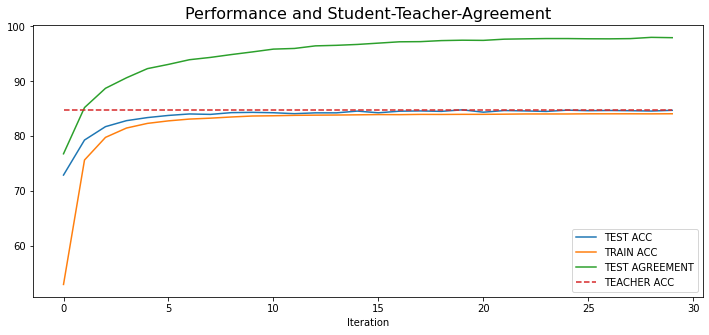

Student Model 2 Test Accuracy final/maximal:0.8464/0.8494 Agreement final/maximal:0.9804/0.9811


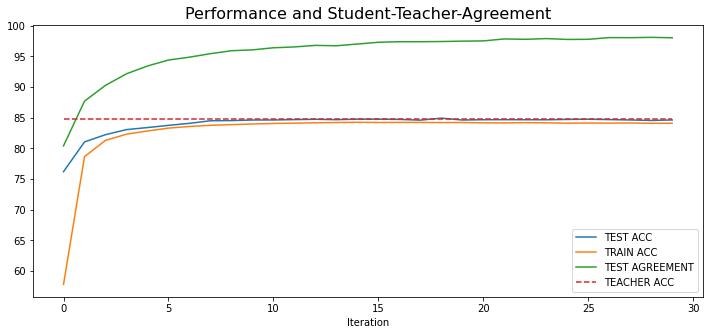

Student Model 3 Test Accuracy final/maximal:0.8472/0.8484 Agreement final/maximal:0.9799/0.9804


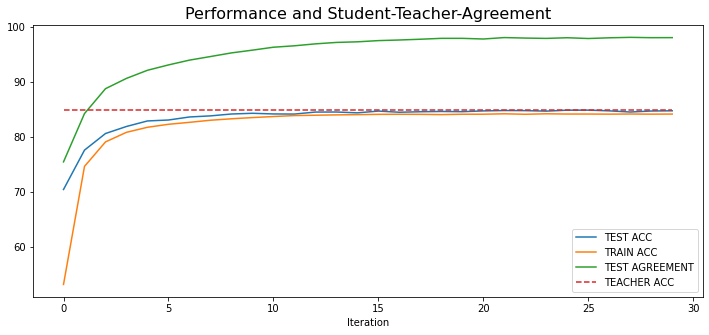

Teacher Model 3 Test Accuracy: 0.8474
Student Model 1 Test Accuracy final/maximal:0.8421/0.8444 Agreement final/maximal:0.9816/0.9816


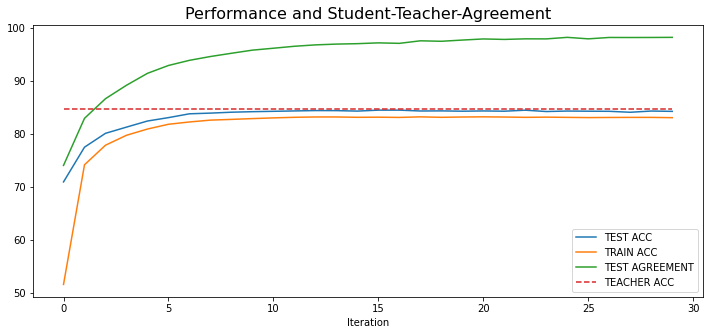

Student Model 2 Test Accuracy final/maximal:0.8416/0.8442 Agreement final/maximal:0.9814/0.9814


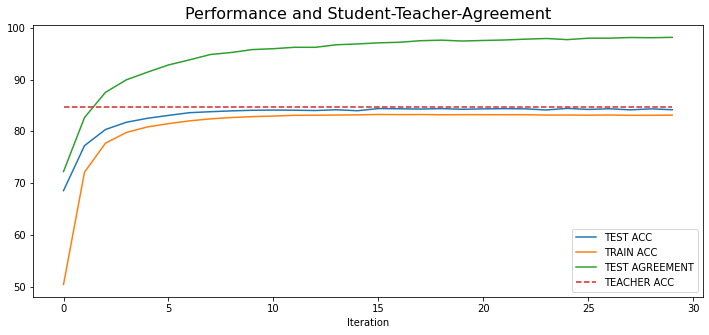

Student Model 3 Test Accuracy final/maximal:0.8399/0.8428 Agreement final/maximal:0.9784/0.9804


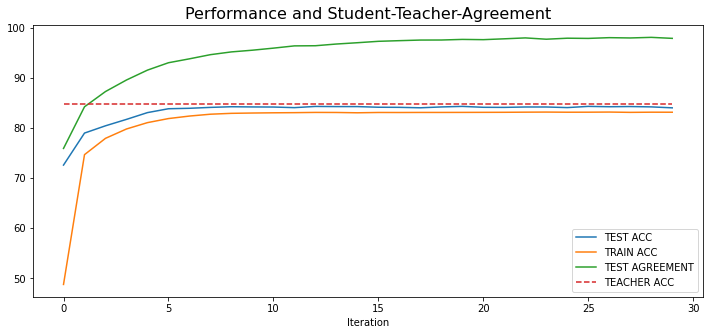

In [46]:
def run_experiment(alpha, num_teach, num_stud, reg):
  '''
  Using alpha value in obj. function of student training.
  Executing the following num_teach many times:
  1. Pre-Training the teacher model on 200 randomly selected MNIST samples 
  2. Training student model using teacher and full MNIST data (num_stud) times
  '''
  teach_perf = []
  stud_perf = [[] for i in range(num_teach)] 
  agr = [[] for i in range(num_teach)]
  for i in range(num_teach):
    teacher = LeNet()
    tr, ts = train_teacher(teacher, 100, 0.001, verbose=0, reg=reg)
    print("Teacher Model {} Test Accuracy: {}".format(i+1, round(np.max(ts),4)))
    teacher_performance = np.max(ts) 
    teach_perf.append(teacher_performance)
    teacher.load_weights("best_teacher") #change teacher to best performing model 
    for j in range(num_stud):
      student = LeNet()
      tr, ts, tr_a, ts_a = run_distillation(teacher, student, alpha=alpha, tau=20, mb=100,\
                                lr=1e-4, epochs=30, verbose=0)
      print("Student Model {} Test Accuracy final/maximal:{}/{} Agreement final/maximal:{}/{}"\
            .format(j+1, round(ts[-1],4), round(np.max(ts),4), round(ts_a[-1],4), round(np.max(ts_a),4)))
      stud_perf[i].append(np.max(ts))
      agr[i].append(np.max(ts_a))
      plotting_function('Performance and Student-Teacher-Agreement', tr, ts, teacher_performance, ts_a, agr=True)
  return np.array(teach_perf), np.array(stud_perf), np.array(agr)
teach_perf, stud_perf, agr = run_experiment(alpha=0, num_teach=3, num_stud=3, reg=0.5)

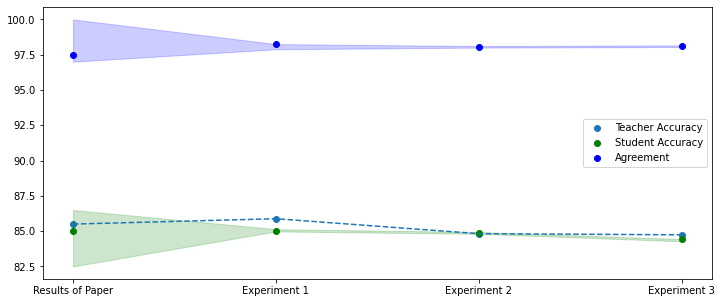

In [47]:
#@title Comparison with Results of Paper
#adding author's results
auth_teach = .855
auth_studs = np.array([.825, .85, .865])
auth_agr = np.array([.97, .975, 1.0])
teach_perf = np.hstack((auth_teach, teach_perf))
stud_perf = np.vstack((auth_studs, stud_perf))
agr = np.vstack((auth_agr, agr))

middle_stud_perf = np.array([np.delete(l, [np.argmin(l), np.argmax(l)]) for l in stud_perf])
middle_agr = np.array([np.delete(l, [np.argmin(l), np.argmax(l)]) for l in agr])
fig, ax = plt.subplots(figsize=(12,5)) 
x = [1, 2, 3, 4]
ax.scatter(x, teach_perf*100, label='Teacher Accuracy')
ax.plot(x, teach_perf*100, '--')
ax.fill_between(x, np.min(stud_perf*100, axis=1), np.max(stud_perf*100, axis=1), color='g', alpha=0.2)
ax.scatter(x, middle_stud_perf*100, color='g', label='Student Accuracy')
ax.fill_between(x, np.min(agr*100, axis=1), np.max(agr*100, axis=1), color='b', alpha=0.2)
ax.scatter(x, middle_agr*100, color='b', label='Agreement')
ax.set_xticks(x)
ax.set_xticklabels(["Results of Paper", "Experiment 1", "Experiment 2", "Experiment 3"])

ax.legend(loc='center right')
plt.show()

My results, compared to the paper, show a lower variation in student performance (green area) and student-teacher-agreement (blue area). Overall, performance and agreement of student and teacher are similar to the values reported by Stanton et al. [3]. 

## Unregularized Teacher Model 
Below I conduct exactly the same experiment except that no regularization is added when training the teacher.  

Teacher Model 1 Test Accuracy: 0.8376
Student Model 1 Test Accuracy final/maximal:0.8513/0.8562 Agreement final/maximal:0.9337/0.9338


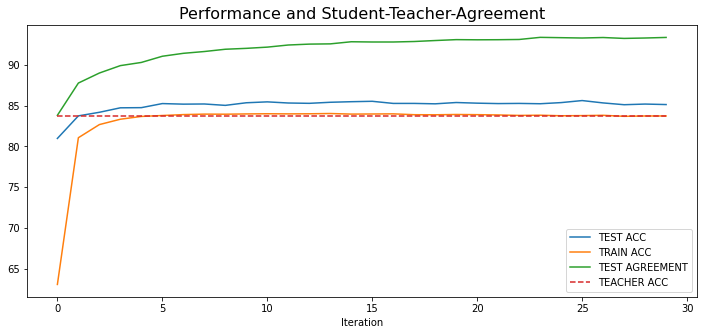

Student Model 2 Test Accuracy final/maximal:0.8476/0.8527 Agreement final/maximal:0.937/0.937


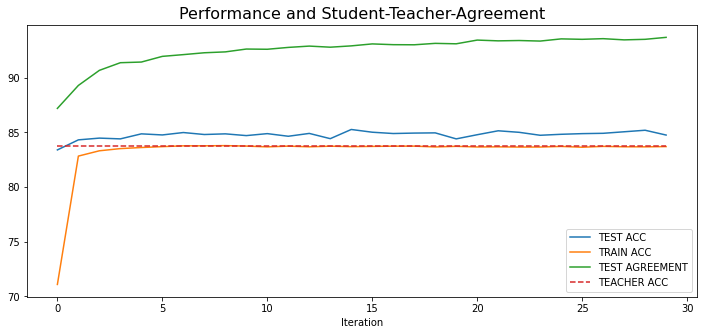

Student Model 3 Test Accuracy final/maximal:0.8451/0.8544 Agreement final/maximal:0.9358/0.9358


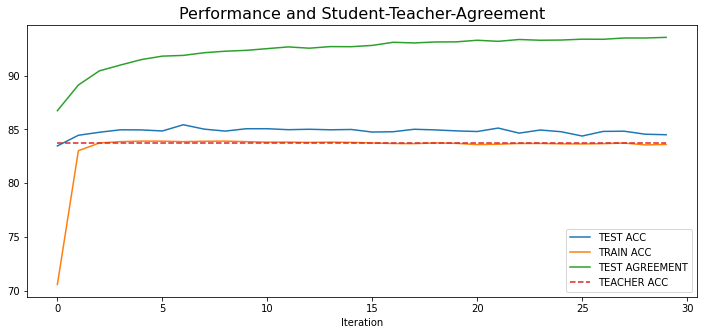

Teacher Model 2 Test Accuracy: 0.8417
Student Model 1 Test Accuracy final/maximal:0.8576/0.8609 Agreement final/maximal:0.9279/0.9279


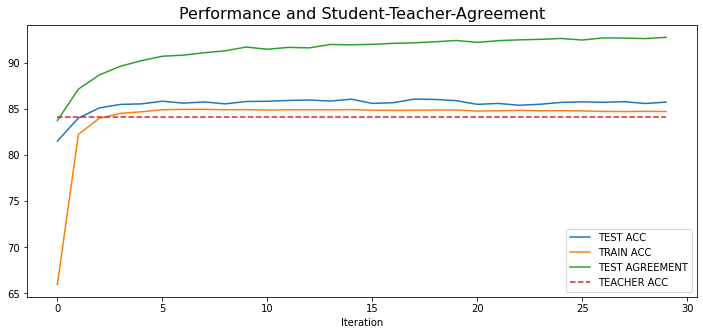

Student Model 2 Test Accuracy final/maximal:0.851/0.8592 Agreement final/maximal:0.9313/0.9325


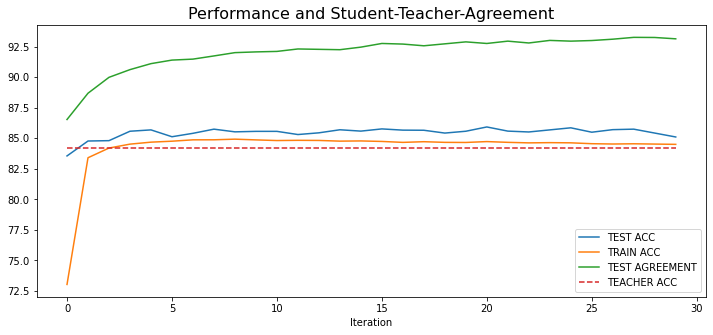

Student Model 3 Test Accuracy final/maximal:0.8566/0.8611 Agreement final/maximal:0.9254/0.9273


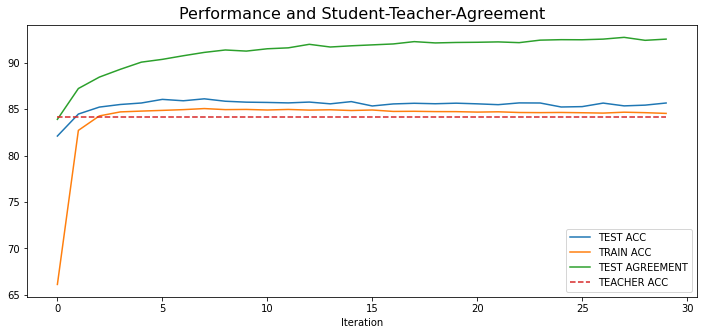

Teacher Model 3 Test Accuracy: 0.8317
Student Model 1 Test Accuracy final/maximal:0.851/0.8587 Agreement final/maximal:0.9169/0.9171


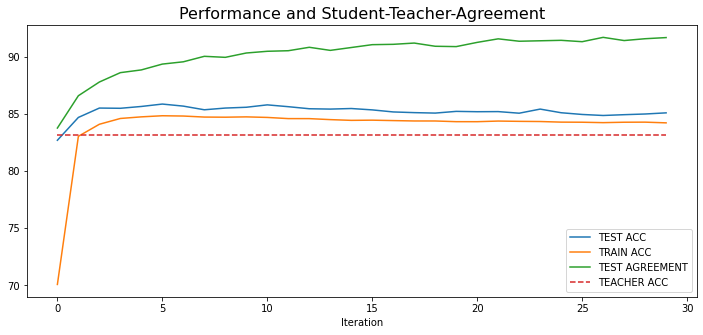

Student Model 2 Test Accuracy final/maximal:0.8509/0.8581 Agreement final/maximal:0.9173/0.9185


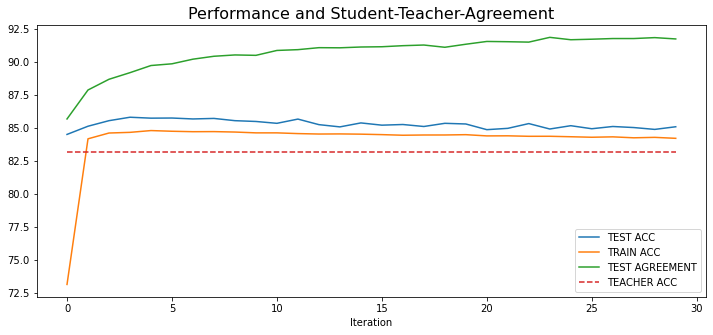

Student Model 3 Test Accuracy final/maximal:0.8527/0.8589 Agreement final/maximal:0.9179/0.9181


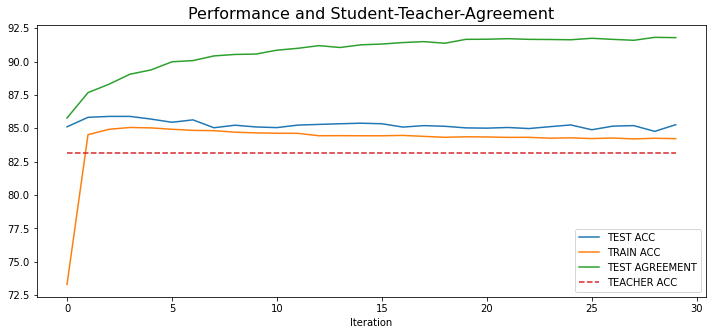

In [48]:
teach_perf, stud_perf, agr = run_experiment(alpha=0, num_teach=3, num_stud=3, reg=0)

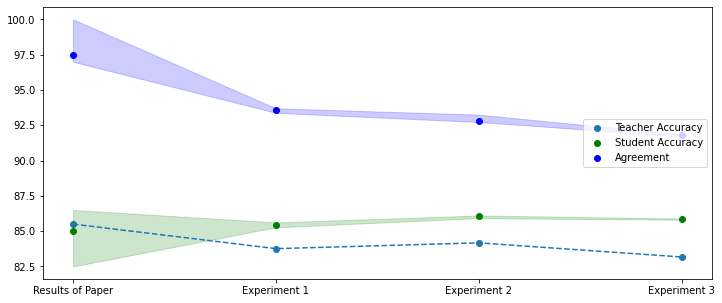

In [49]:
#@title Results - Unregularized Teacher
#adding author's results
auth_teach = .855
auth_studs = np.array([.825, .85, .865])
auth_agr = np.array([.97, .975, 1.0])
teach_perf = np.hstack((auth_teach, teach_perf))
stud_perf = np.vstack((auth_studs, stud_perf))
agr = np.vstack((auth_agr, agr))

middle_stud_perf = np.array([np.delete(l, [np.argmin(l), np.argmax(l)]) for l in stud_perf])
middle_agr = np.array([np.delete(l, [np.argmin(l), np.argmax(l)]) for l in agr])
fig, ax = plt.subplots(figsize=(12,5)) 
x = [1, 2, 3, 4]
ax.scatter(x, teach_perf*100, label='Teacher Accuracy')
ax.plot(x, teach_perf*100, '--')
ax.fill_between(x, np.min(stud_perf*100, axis=1), np.max(stud_perf*100, axis=1), color='g', alpha=0.2)
ax.scatter(x, middle_stud_perf*100, color='g', label='Student Accuracy')
ax.fill_between(x, np.min(agr*100, axis=1), np.max(agr*100, axis=1), color='b', alpha=0.2)
ax.scatter(x, middle_agr*100, color='b', label='Agreement')
ax.set_xticks(x)
ax.set_xticklabels(["Results of Paper", "Experiment 1", "Experiment 2", "Experiment 3"])

ax.legend(loc='center right')
plt.show()

- When the teacher is not regularized the student appears to  be much more likely to outperform the teacher 
- Even more interestingly, despite the lower teacher performance, the student model performs better than in the regularized case  

## Conclusions and Future Research

- Knowledge distillation can train a model without accessing ground truth labels
- Knowledge distillation can be used to achieve high performance at inference with a small model 
- Why is test accuracy higher than train?
- Investigate effect of regularization of teacher 
- For this effect maybe start with the following paper:
  - $\textit{Revisiting Knowledge Distillation via Label Smoothing Regularization}$ https://openaccess.thecvf.com/content_CVPR_2020/papers/Yuan_Revisiting_Knowledge_Distillation_via_Label_Smoothing_Regularization_CVPR_2020_paper.pdf

## References

[1] Hinton G, Vinyals O, Dean J. 2015. Distilling the Knowledge in a
Neural Network.

[2] LeCun Y, Bottou L, Bengio Y, Haffner P. 1998. Gradient-Based Learning Applied to Document Recognition. In: Proceedings of the IEEE, volume 86. pp. 2278 - 2324. 

[3] Stanton S, Izmailov P, Kirichenko P, Alemi A, Wilson A. 2021. Does Knowledge Distillation Really Work?. 35th Conference on Neural Information Processing Systems (NeurIPS 2021), Sydney, Australia.

[4] https://towardsdatascience.com/knowledge-distillation-simplified-dd4973dbc764. Time of access: 02.02.2022.